In [1]:
import numpy as np
import pandas as pd

from aeon.visualisation import plot_critical_difference
from aeon.visualisation import plot_pairwise_scatter

from labicompare.visualization import generate_mcm, critical_difference_diagram

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler

import json

In [2]:
mlp = pd.read_csv('results/[end] MLP.csv')
mlp = mlp.drop('run', axis=1)

fcn = pd.read_csv('results/[end] FCN.csv')
fcn = fcn.drop('run', axis=1)

mini_rocket = pd.read_csv('results/[end] MiniROCKET.csv')
mini_rocket = mini_rocket.drop('run', axis=1)

xgboost = pd.read_csv('results/[end] XGBoost.csv')
xgboost = xgboost.drop('run', axis=1)

random_forest = pd.read_csv('results/[end] RandomForest.csv')
random_forest = random_forest.drop('run', axis=1)

convtran = pd.read_csv('results/ConvTran.csv')
convtran = convtran.drop('run', axis=1)

tsermamba = pd.read_csv('results/TSERMamba.csv')
tsermamba = tsermamba.drop('run', axis=1)

In [3]:
for model in [mlp, fcn, xgboost, random_forest, mini_rocket, convtran, tsermamba]:
    model['run'] = model.groupby('dataset').cumcount() + 1

In [4]:
mlp = mlp.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
fcn = fcn.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
convtran = convtran.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
tsermamba = tsermamba.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
mini_rocket = mini_rocket.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
xgboost = xgboost.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])
random_forest = random_forest.sort_values(by=['dataset', 'run']).set_index(['dataset','run'])

In [5]:
metrics = pd.DataFrame({
    'mlp': mlp['rmse'],
    'fcn': fcn['rmse'],
    'convtran': convtran['rmse'],
    'tsermamba': tsermamba['rmse'],
    'mini_rocket': mini_rocket['rmse'],
    'xgboost': xgboost['rmse'],
    'random_forest': random_forest['rmse']
})

metrics = metrics.dropna(subset=['convtran','tsermamba'])

metrics

mlp        fcn   convtran  tsermamba  \
dataset            run                                               
AppliancesEnergy   1     3.416436   2.829873   2.778814   3.541914   
                   2     3.244504   2.825369   2.629588   3.523867   
                   3     3.465702   2.991828   2.288087   3.331688   
                   4     3.739366   2.507369   2.553841   3.406784   
                   5     3.345403   3.017629   2.704078   4.121892   
...                           ...        ...        ...        ...   
NewsTitleSentiment 2     0.138132   0.162167   0.156010   0.138191   
                   3     0.138153   0.160208   0.156254   0.138113   
                   4     0.149852   0.160776   0.155677   0.138139   
                   5     0.138106   0.162042   0.155394   0.138122   
PPGDalia           1    19.632797  14.337798  12.205875  15.611127   

                        mini_rocket    xgboost  random_forest  
dataset            run                                         
AppliancesEnergy   1       2.517430   2.323818       2.285652  
                   2       2.414427   2.610751       2.313971  
                   3       2.508096   2.617999       2.385531  
                   4       2.338853   2.551161       2.366201  
                   5       2.359651   2.112688       2.284756  
...                             ...        ...            ...  
NewsTitleSentiment 2       0.139894   0.141297       0.142153  
                   3       0.140065   0.141583       0.141921  
                   4       0.139897   0.140962       0.142140  
                   5       0.140073   0.141225       0.142059  
PPGDalia           1      13.575067  16.268086      18.883754  

[76 rows x 7 columns]

In [6]:
ranks = metrics.rank(axis=1)
mean_ranks = ranks.groupby(level='dataset').mean()
mean_ranks

,mlp,fcn,convtran,tsermamba,mini_rocket,xgboost,random_forest
dataset,,,,,,,
AppliancesEnergy,6.4,4.6,3.6,6.6,2.4,2.8,1.6
AustraliaRainfall,1.0,3.0,6.0,2.0,5.0,7.0,4.0
BIDMC32HR,7.0,2.0,1.0,5.0,3.0,4.0,6.0
BIDMC32RR,2.4,3.6,2.2,6.8,5.2,4.6,3.2
BIDMC32SpO2,1.0,6.0,5.0,3.0,7.0,4.0,2.0
BeijingPM10Quality,2.8,1.2,7.0,2.8,5.6,5.4,3.2
BeijingPM25Quality,2.4,1.0,6.8,2.6,4.8,6.0,4.4
BenzeneConcentration,5.0,1.2,2.0,6.0,7.0,4.0,2.8
Covid3Month,4.4,4.8,6.4,3.4,1.0,5.2,2.8


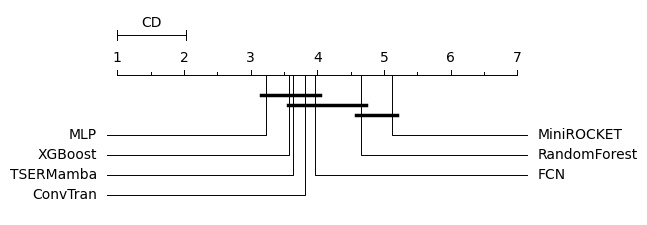

In [7]:
name = {'mlp':'MLP', 'fcn':'FCN', 'convtran':'ConvTran', 'tsermamba':'TSERMamba',
        'mini_rocket':'MiniROCKET', 'xgboost':'XGBoost', 'random_forest':'RandomForest'}
metrics.columns = [name[col] for col in metrics.columns]

fig_nem = critical_difference_diagram(
    metrics,
    test='nemenyi',
    alpha=0.05
)

# fig_wil = critical_difference_diagram(
#     metrics,
#     test='wilcoxon',
#     alpha=0.05
# )   

In [8]:
ranks = metrics.rank(axis=1)
all_ranks = sorted(list(set(ranks.values.flatten().astype(int).tolist())))

# Count occurrences of each rank per model
ranks_counts = {
    col: ranks[col].value_counts().reindex(all_ranks, fill_value=0).sort_index()
    for col in ranks.columns
}

# Create DataFrame of rank counts
ranks_df = pd.DataFrame(ranks_counts)
ranks_df = ranks_df[metrics.columns]

# Transpose: models as rows, ranks as columns
ranks_df_t = ranks_df.T
ranks_df_t.columns = [f"{c}º" for c in ranks_df_t.columns]

# Sort by number of 1st, 2nd, ... positions (descending)
ranks_df_t = ranks_df_t.sort_values(
    by=ranks_df_t.columns.tolist(),
    ascending=[False] * len(ranks_df_t.columns)
)

# Compute mean rank (weighted average of positions)
positions = np.array(all_ranks)
ranks_df_t["Mean"] = (
    (ranks_df_t.values[:, :len(all_ranks)] * positions).sum(axis=1)
    / ranks_df_t.iloc[:, :len(all_ranks)].sum(axis=1)
)

# Reorder columns: ranks first, then mean
rank_cols = [f"{c}º" for c in all_ranks]
ranks_df_t = ranks_df_t[rank_cols + ["Mean"]]

ranks_df_t

,1º,2º,3º,4º,5º,6º,7º,Mean
MiniROCKET,30,11,12,4,6,6,7,2.881579
FCN,14,15,5,2,11,18,11,4.039474
ConvTran,11,10,13,7,7,11,17,4.184211
TSERMamba,7,15,11,6,2,17,18,4.368421
RandomForest,7,9,24,25,9,2,0,3.342105
MLP,6,11,4,6,16,13,20,4.763158
XGBoost,1,5,7,26,25,9,3,4.421053


Processing RandomForest, XGBoost:   0%|          | 0/7 [00:00<?, ?it/s]   


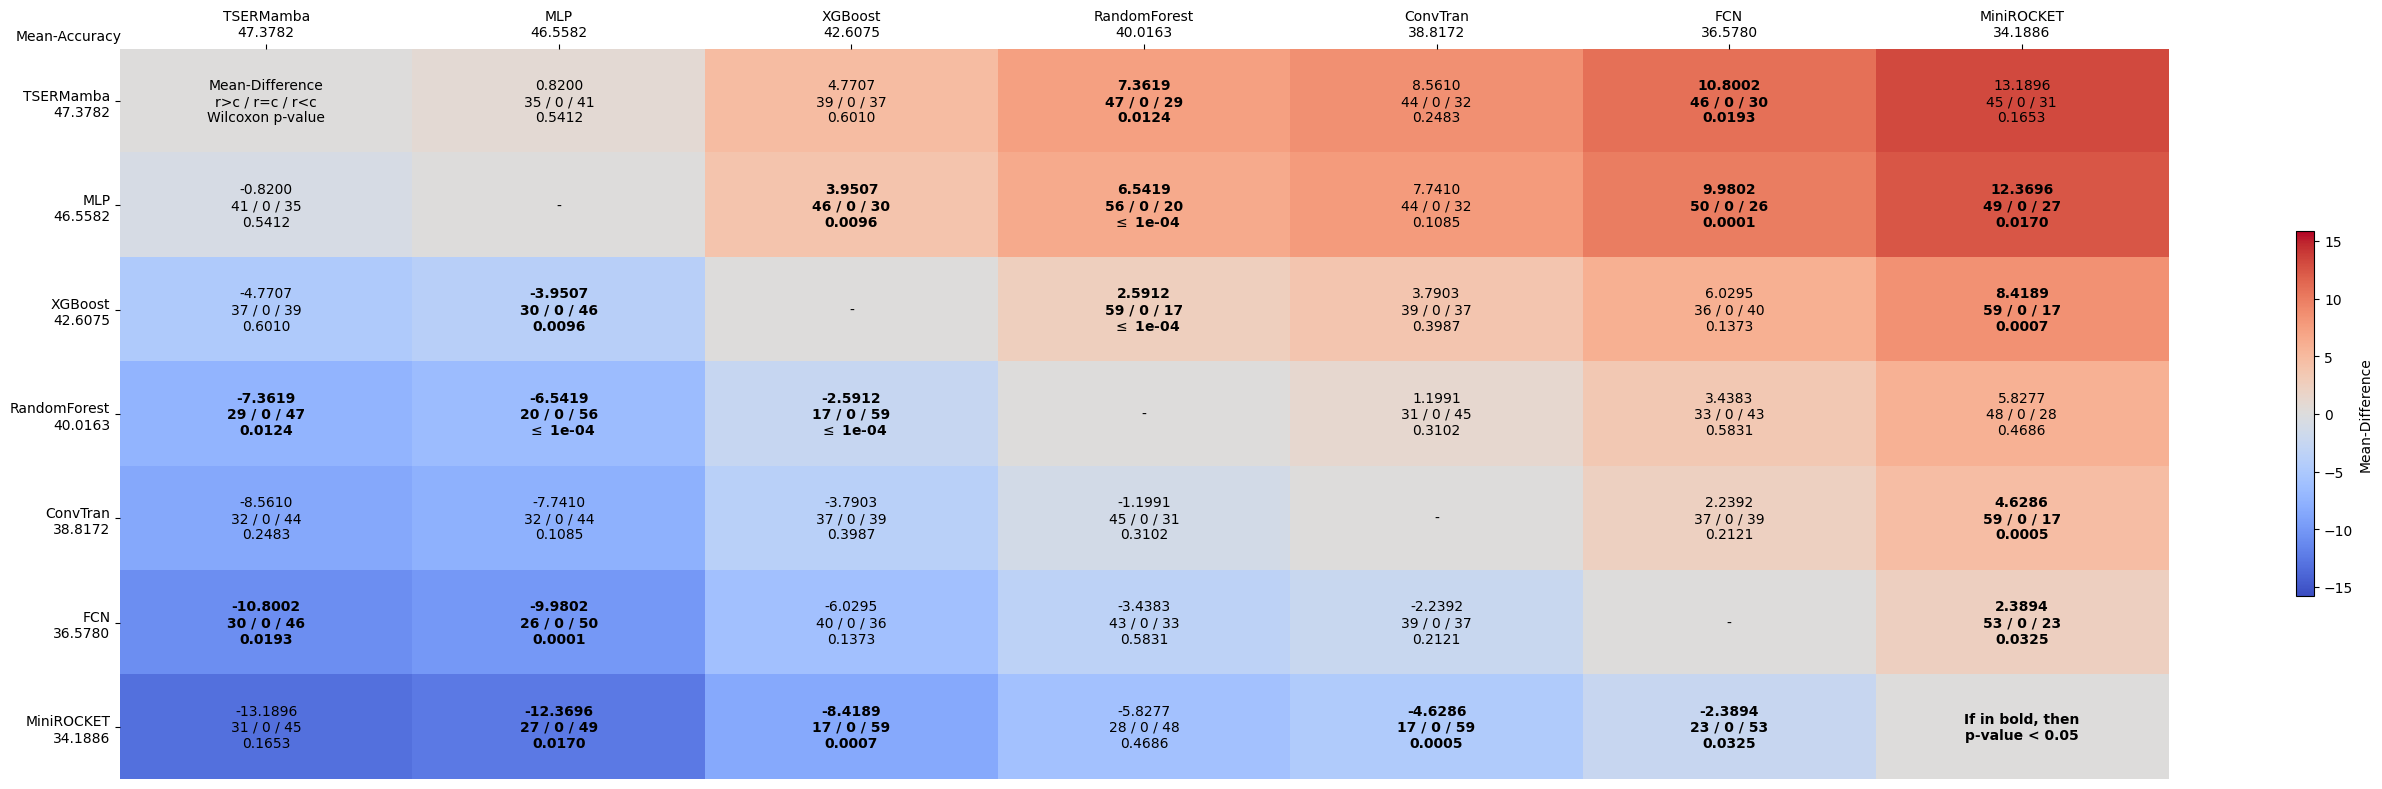

In [9]:
fig = generate_mcm(metrics)

O que discutir
- CDD
- MCM
- Distribuições dos rankings
    - (ins)estabilidade dos rankings
- Tempo de exec para justificar os datasets
- Qtd de parâmetros
- Análise qualitativa dos datasets em que os modelos adaptados foram bem/mal
- TSERMamba vs ConvTran
- Distribution of relative RMSE  (BoxPlot from TSER2 paper)